In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import global_visualize_wo_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_regularization
from gaminet.utils import plot_trajectory

In [2]:
task_type = "Classification"

data = pd.read_csv("./bank.csv", sep=";")
meta_info = json.load(open("./data_types.json"))
data['month'] = data['month'].replace('jan', 1).replace('feb', 2).replace('mar', 3).replace('apr', 4).\
                              replace('may', 5).replace('jun', 6).replace('jul', 7).replace('aug', 8).\
                              replace('sep', 9).replace('oct', 10).replace('nov', 11).replace('dec', 12)
x, y = data.iloc[:,:-1].values, data.iloc[:,[-1]].values
xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
for i, (key, item) in enumerate(meta_info.items()):
    if item['type'] == 'target':
        enc = OrdinalEncoder()
        enc.fit(y)
        y = enc.transform(y)
        meta_info[key]['values'] = enc.categories_[0].tolist()
    elif item['type'] == 'categorical':
        enc = OrdinalEncoder()
        xx[:,[i]] = enc.fit_transform(x[:,[i]])
        meta_info[key]['values'] = []
        for item in enc.categories_[0].tolist():
            try:
                if item == int(item):
                    meta_info[key]['values'].append(str(int(item)))
                else:
                    meta_info[key]['values'].append(str(item))
            except ValueError:
                meta_info[key]['values'].append(str(item))
    else:
        sx = MinMaxScaler((0, 1))
        xx[:,[i]] = sx.fit_transform(x[:,[i]])
        meta_info[key]['scaler'] = sx
train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y, test_size=0.2, random_state=0)

In [3]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def auc(label, pred, scaler=None):
    return roc_auc_score(label, pred)

get_metric = metric_wrapper(auc, None)

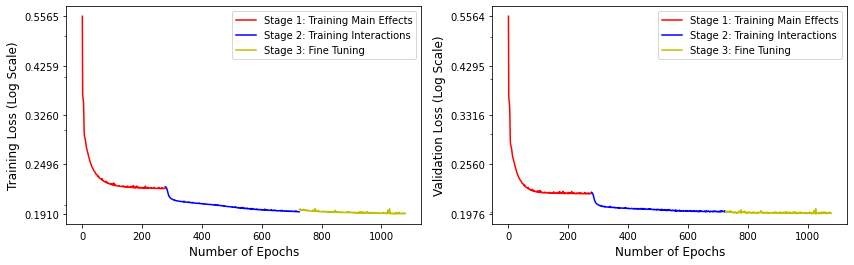

W1028 16:05:16.896645 140131601741632 backend_ps.py:735] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1028 16:05:16.908603 140131601741632 backend_ps.py:735] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1028 16:05:17.001271 140131601741632 backend_ps.py:735] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W1028 16:05:17.002412 140131601741632 backend_ps.py:735] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


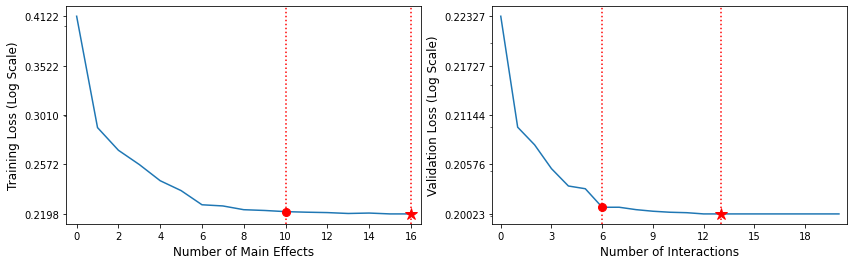

In [4]:
folder = "./results/"
if not os.path.exists(folder):
    os.makedirs(folder)

model_bank = GAMINet(meta_info=meta_info, interact_num=20,
            interact_arch=[40] * 5, subnet_arch=[40] * 5, 
            lr_bp=0.0001, batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
            main_effect_epochs=5000, interaction_epochs=5000, tuning_epochs=500, early_stop_thres=50,
            heredity=True, loss_threshold=0.01, reg_clarity=0.1,
            verbose=False, val_ratio=0.2, random_state=0)
model_bank.fit(train_x, train_y)
data_dict_logs = model_bank.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=folder, name="bank_traj", save_png=True, save_eps=True)
plot_regularization(data_dict_logs, folder=folder, name="bank_regu", save_png=True, save_eps=True)

Global Interpretation

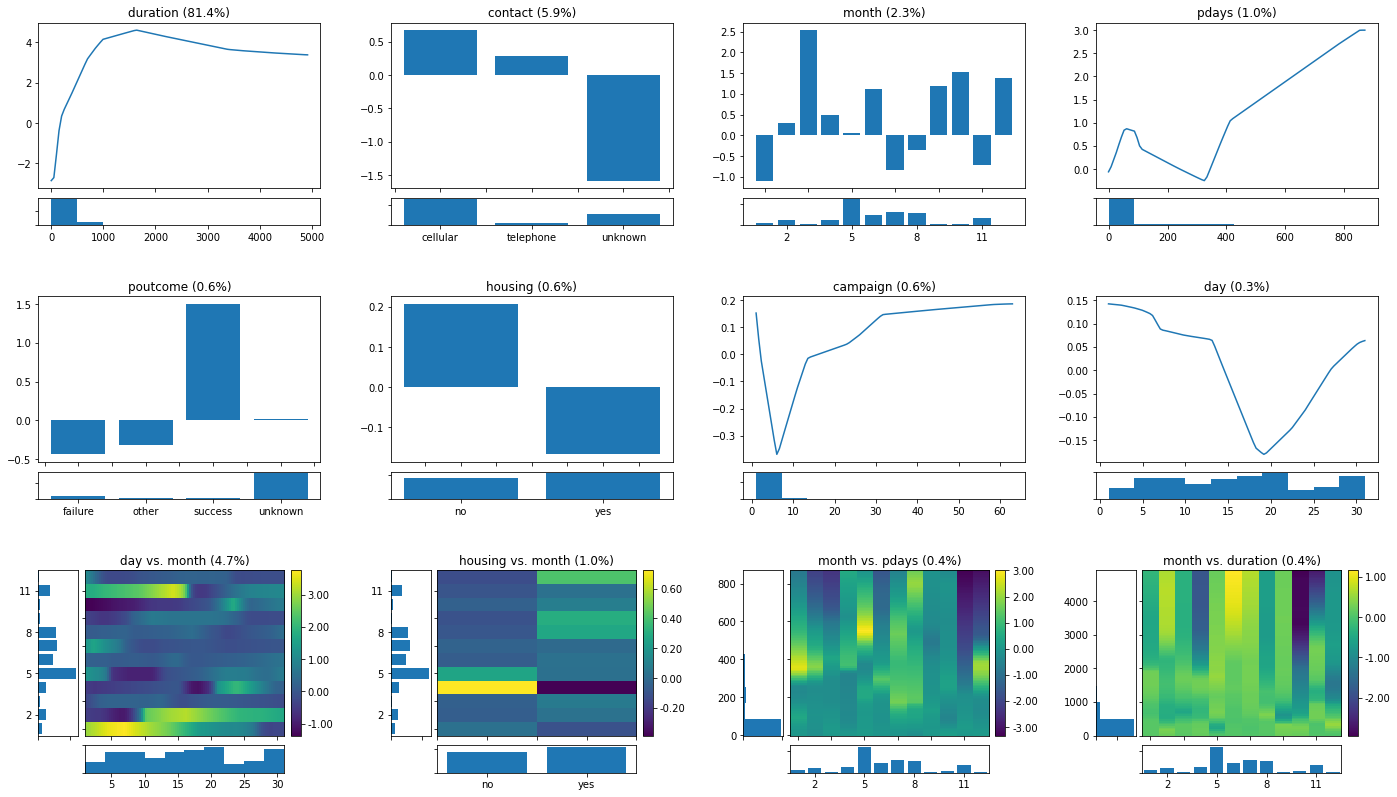

In [5]:
data_dict_global = model_bank.global_explain(save_dict=True, folder=folder, name="bank_global")
global_visualize_density(data_dict_global, folder=folder, name="bank_global",
                         main_effect_num=8, interaction_num=4, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

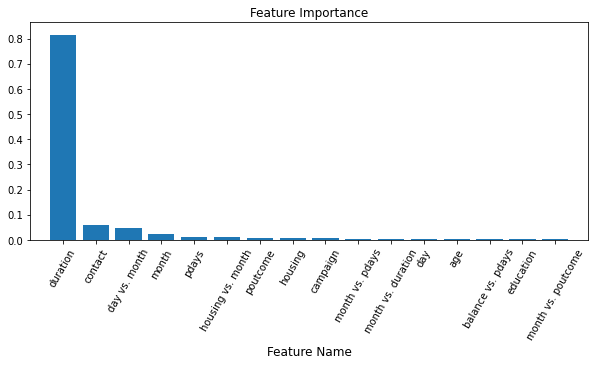

In [6]:
feature_importance_visualize(data_dict_global)

Interpret the prediction of a test sample

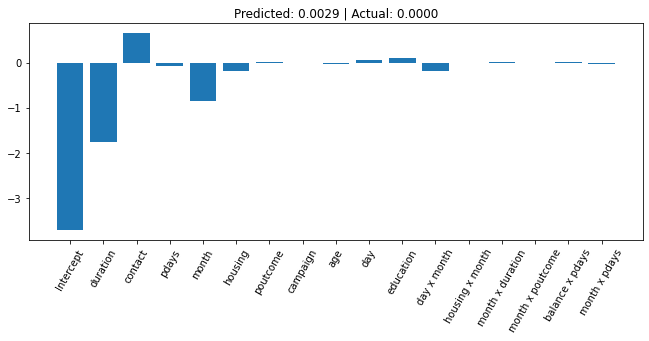

In [7]:
data_dict_local = model_bank.local_explain(test_x[[0]], test_y[[0]], save_dict=False)
local_visualize(data_dict_local, save_png=False)